<a href="https://colab.research.google.com/github/jjsmartin/digit-recognizer/blob/main/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [288]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kerastuner as kt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Setup

In [240]:
# upload api key in kaggle.json
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jonathanmartin","key":"76269bf5445db6d3e3fc46d21f08de6e"}'}

In [243]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


# Get the data

In [244]:
!kaggle competitions download -c digit-recognizer

 85% 13.0M/15.3M [00:01<00:00, 14.8MB/s]
100% 15.3M/15.3M [00:01<00:00, 9.42MB/s]


In [252]:
!unzip -qq digit-recognizer.zip


replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [257]:
#(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [256]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [260]:
train.shape, test.shape

((42000, 785), (28000, 784))

In [277]:
def prepare_train_data(df):

  labels = df.iloc[:, 0].values
  pixels = df.iloc[:, 1:].values
  images = pixels.reshape(-1, 28, 28, 1)

  return images, labels


def prepare_test_data(df):
  images = df.values.reshape(-1, 28, 28, 1)

  return images

train_images, train_labels = prepare_train_data(train)
test_images = prepare_test_data(test)

In [269]:
split_point = int(0.8 * train_images.shape[0])
X_train = train_images[:split_point]
y_train = train_labels[:split_point]

X_val = train_images[split_point:]
y_val = train_labels[split_point:]

X_train.shape, X_val.shape

((33600, 28, 28, 1), (8400, 28, 28, 1))

In [270]:
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1)
])

In [271]:
inputs = layers.Input(shape=(28,28,1))

x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.BatchNormalization()(x)

x = keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.BatchNormalization()(x)

x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs, outputs)

In [272]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="mnist.keras", monitor="val_loss",save_best_only=True)
    ]

model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    #batch_size=32,
    callbacks=callbacks
    )

Epoch 1/20
1050/1050 [==============================] - 11s 7ms/step - loss: 0.1091 - accuracy: 0.9668 - val_loss: 0.0594 - val_accuracy: 0.9835
Epoch 2/20
1050/1050 [==============================] - 8s 8ms/step - loss: 0.0402 - accuracy: 0.9871 - val_loss: 0.0741 - val_accuracy: 0.9807
Epoch 3/20
1050/1050 [==============================] - 7s 7ms/step - loss: 0.0275 - accuracy: 0.9910 - val_loss: 0.0325 - val_accuracy: 0.9921
Epoch 4/20
1050/1050 [==============================] - 8s 8ms/step - loss: 0.0154 - accuracy: 0.9953 - val_loss: 0.0315 - val_accuracy: 0.9935
Epoch 5/20
1050/1050 [==============================] - 8s 7ms/step - loss: 0.0135 - accuracy: 0.9957 - val_loss: 0.0334 - val_accuracy: 0.9925
Epoch 6/20
1050/1050 [==============================] - 7s 6ms/step - loss: 0.0098 - accuracy: 0.9968 - val_loss: 0.0266 - val_accuracy: 0.9939
Epoch 7/20
1050/1050 [==============================] - 7s 6ms/step - loss: 0.0087 - accuracy: 0.9972 - val_loss: 0.0380 - val_accuracy

In [279]:
model = keras.models.load_model("mnist.keras")
print(f"Best validation accuracy: {model.evaluate(X_val, y_val)[1]: .3f}")

263/263 [==============================] - 1s 4ms/step - loss: 0.0266 - accuracy: 0.9939
Best validation accuracy:  0.994


Text(0.5, 1.0, 'loss')

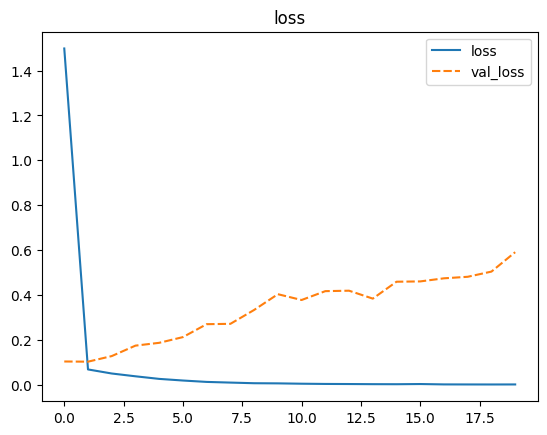

In [280]:
history_df = pd.DataFrame(history.history)
sns.lineplot(data=history_df.filter(regex="loss"))
plt.title("loss")

Text(0.5, 1.0, 'accuracy')

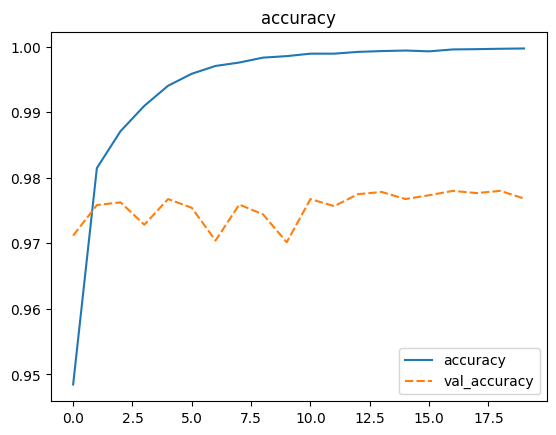

In [281]:
sns.lineplot(data=history_df.filter(regex="accuracy"))
plt.title("accuracy")

# Refit on all the data

In [ ]:
train_images

In [284]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

model.fit(
    train_images, train_labels,
    epochs=20
    )

Epoch 1/20
1313/1313 [==============================] - 11s 6ms/step - loss: 0.0155 - accuracy: 0.9958
Epoch 2/20
1313/1313 [==============================] - 8s 6ms/step - loss: 0.0098 - accuracy: 0.9972
Epoch 3/20
1313/1313 [==============================] - 8s 6ms/step - loss: 0.0066 - accuracy: 0.9977
Epoch 4/20
1313/1313 [==============================] - 9s 7ms/step - loss: 0.0056 - accuracy: 0.9980
Epoch 5/20
1313/1313 [==============================] - 9s 7ms/step - loss: 0.0052 - accuracy: 0.9984
Epoch 6/20
1313/1313 [==============================] - 8s 6ms/step - loss: 0.0036 - accuracy: 0.9987
Epoch 7/20
1313/1313 [==============================] - 7s 5ms/step - loss: 0.0033 - accuracy: 0.9988
Epoch 8/20
1313/1313 [==============================] - 8s 6ms/step - loss: 0.0035 - accuracy: 0.9989
Epoch 9/20
1313/1313 [==============================] - 8s 6ms/step - loss: 0.0018 - accuracy: 0.9995
Epoch 10/20
1313/1313 [==============================] - 8s 6ms/step - loss: 0.00

# Predictions for the test set

In [285]:
preds = model.predict(test_images)

875/875 [==============================] - 2s 2ms/step


In [289]:
predicted_labels = np.argmax(preds, axis=1)

In [297]:
import random

Text(0.5, 1.0, 'Predicted label for item 5862: 7')

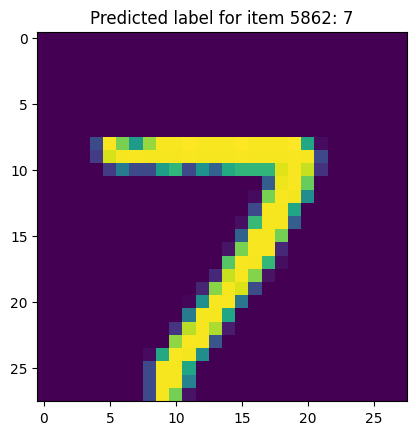

In [304]:
# sense check
n=random.randint(0, test.shape[0])
plt.imshow(test_images[n])
plt.title(f"Predicted label for item {n}: {predicted_labels[n]}")

# Submission

In [306]:
submission = pd.read_csv("sample_submission.csv")
submission["Label"] = predicted_labels

In [307]:
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [308]:
submission.to_csv("submission.csv", index=False)

In [309]:
!kaggle competitions submit -c digit-recognizer -f submission.csv -m "no tuning"

100% 208k/208k [00:03<00:00, 67.5kB/s]
Successfully submitted to Digit Recognizer

# results
https://www.kaggle.com/competitions/digit-recognizer/submissions